<a href="https://colab.research.google.com/github/tpeat/titanic-ml/blob/main/titanic_MOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [325]:
%pylab inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv

!pip3 install pandas
import pandas as pd
# Numpy lets us work with arrays
import numpy as np

# Sklearn provides various modules with a common API
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate

!pip install deap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
import operator
import itertools

from treelib import Node, Tree
import pygraphviz as pgv

import math

# turn off warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'tanh']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [233]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('processed_train.csv').set_index("PassengerId")
test_data = pd.read_csv('processed_test.csv').set_index("PassengerId")

df = pd.concat([train_data, test_data], axis=0, sort=False)

In [234]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LastName,IsWomanOrBoy,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Single,SmallF,MedF,LargeF,Deck
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22.0,1,0,7.2500,2,10,100,0,0,0.0,0.0,1,0,1,0,0,7
2,1.0,1,0,38.0,1,0,71.2833,0,11,182,1,1,1.0,1.0,0,0,1,0,0,2
3,1.0,3,0,26.0,0,0,7.9250,2,9,329,1,1,1.0,1.0,0,1,0,0,0,7
4,1.0,1,0,35.0,1,0,53.1000,2,11,267,1,1,1.0,1.0,0,0,1,0,0,2
5,0.0,3,1,35.0,0,0,8.0500,2,10,15,0,1,1.0,1.0,0,1,0,0,0,7


## Generate valuable constants from df

In [235]:
# average age
mean_age = df.Age.mean()

# 1st quartile
q1_age = np.quantile(df.Age, 0.25)
# quartile 3
q3_age = np.quantile(df.Age, 0.75)


# mode of passenger class
mode_class = df.Pclass.value_counts().idxmax()

# mode siblings
mode_sibs = df.SibSp.value_counts().idxmax()

# mode parnets
mode_parents = df.Parch.value_counts().idxmax()

# mean fare price
mean_fare = df.Fare.mean()

In [236]:
RANDOM_SEED=10
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_SEED)

In [237]:
# create fitness for MO: FP and FN
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [317]:
# helper functions for primitives
def get_random():
    r = random.random()
    r2 = random.randint(0, 2)
    r3 = r + r2 + 0.000000001
    return r3

def relu(a):
    if a < 0:
        return 0
    else:
        return a

def if_then_else(input, output1, output2):
    if input: 
        return output1
    else: 
        return output2

def float_to_bool(f):
    return f > 0

# was not working because of overflow? didn't know that was possible in python
# double scalars issue
def power2(a):
    return a ** 2

def pass_(a):
    return a

def tanh(a):
    return math.tanh(a)

In [318]:
# create primitive set
random.seed(RANDOM_SEED)
# strongly typed so we can ensure that the final output is a boolean
pset = gp.PrimitiveSetTyped("main", itertools.repeat(float, 19), bool) 

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
# pset.addPrimitive(divide_by_zero, [float, float], float)
# pset.addPrimitive(power2, [float], float)


pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(float_to_bool, [float], bool)

# logical comparators
pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.le, [float, float], bool)
pset.addPrimitive(operator.gt, [float, float], bool)
pset.addPrimitive(operator.ge, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# cast negatives to 0 like the relu function
pset.addPrimitive(relu, [float], float)
# random number
# pset.addTerminal(get_random, float)
# just pass on the number
pset.addPrimitive(pass_, [float], float)
# tanh function
pset.addPrimitive(tanh, [float], float)

## Add some random constants
pset.addTerminal(0, bool)
pset.addTerminal(1, bool)
pset.addTerminal(2.0, float)
pset.addTerminal(mean_age, float)
pset.addTerminal(q1_age, int)
pset.addTerminal(q3_age, int)
pset.addTerminal(mode_sibs, int)
pset.addTerminal(mode_parents, int)
pset.addTerminal(mode_class, int)
pset.addTerminal(mean_fare, float)

pset.renameArguments(ARG0='Pclass', ARG1='Sex', ARG2='Age', ARG3='SibSp', ARG4='Parch', ARG5="Fare", ARG6="Embarked",ARG7="Title", ARG8="LastName",
                     ARG9="IsWomanOrBoy", ARG10="WomanOrBoyCount", ARG11="FamilySurvivedCount", ARG12="WomanOrBoySurvived", ARG13="Alone", 
                     ARG14="Single", ARG15="SmallF", ARG16="MedF", ARG17="LargeF", ARG18="Deck")

In [319]:
# create toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [320]:
def eval_function(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    results = [func(*points[x]) for x in range(len(points))]
    tn, fp, fn, tp = confusion_matrix(y_train, results).ravel()
    return fp/(tn + fp), fn/(tp + fn)

In [321]:
# from whiteboard - this is the same implementation made with strictly numpy, and it allows for cross validation
def eval_alt(individual, pset, train, **kwargs):
    func = gp.compile(expr=individual, pset=pset)
    preds = []
    train, truth = train_test_split(train)
    # sepearte train into 
    # for row in fold:
    #     pred = func(*row)
    #     preds.append(pred)
    
    # truth is the y_test dataframe
    preds = np.array(preds)
    fnr = np.sum(np.logical_not(preds[truth == 1])) / np.sum(truth)
    fpr = np.sum(preds[truth == 0]) / np.sum(truth[truth == 0])
    pass

In [332]:
# function to visualize our tree
def visualize(individual):
    # unpack graphs
    nodes, edges, labels = gp.graph(individual)
    # init Tree from treelib
    tree = Tree()
    # create a mapping from child to parent from the edges list (will be costly for large trees)
    parents = dict()
    for parent,kid in edges:
        parents[kid] = parent
    # create and add nodes to tree
    for node in nodes:
        if node not in parents:
            tree.create_node(labels[node], node)
        else:
            tree.create_node(labels[node], node, parent=parents[node])
    # display visualization
    tree.show()

'''
Function doesn't work properly bc it tries to order nodes but can't compare strs to ints
'''

"\nFunction doesn't work properly bc it tries to order nodes but can't compare strs to ints\n"

In [333]:
# graph viz by deap
def visualize2(individual):
    nodes, edges, labels = gp.graph(individual)

    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]

    g.draw("tree.pdf")

In [334]:
toolbox.register("evaluate", eval_function, points=X_train.values, pset=pset)

# experiment with different selection algorithms, mating and mutation algorithms
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=2, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("crossover", gp.cxOnePoint)

toolbox.register("insertion", gp.mutInsert, expr=toolbox.expr_mut, pset=pset)
# toolbox.register("evaluate", eval_function, pset=pset, points=df)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [337]:
expr = gp.genFull(pset, min_=1, max_=5)
tree = gp.PrimitiveTree(expr)
# print(str(tree))
# print(str(eval_function(tree, X_train.values, pset)))
try:
    visualize(toolbox.individual())
except TypeError:
    print("type error")

visualize2(toolbox.individual())

and_
├── 0
└── 1



In [338]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

## Create population

In [339]:
size = 300
# create a population of size size
population = toolbox.population(size)
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

# sort by pareto dom??
dominated = [ind for ind in population if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in population if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in population if not ind in dominated and not ind in dominators]

# report
print(len(dominated))
print((dominators[1].fitness.values[1]))
print(len(others))

30
0.21428571428571427
261


## Plot Objective space

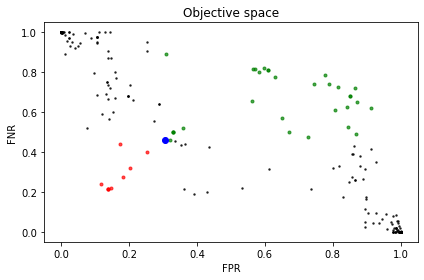

In [340]:
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('FPR');plt.ylabel('FNR');
plt.title('Objective space');
plt.tight_layout()
plt.show()

In [341]:
# try mutpb = 0.2, higher num gens
def evol_loop(ngen = 80, cxpb = 0.5, mutpb = 0.1, select_method="NSGA2", lambda_ = 100):
    hof = tools.ParetoFront()

    # list for metrix (might not care about them)
    avg_list = []
    max_list = []
    min_list = []

    best_ind = tools.selBest(population, 1)[0]
    gen_best = 0

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields


    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    record = stats.compile(population)
    logbook.record(gen=0, nevals=len(invalid_ind), **record)

    print(logbook.stream)

    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = [toolbox.clone(ind) for ind in population]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                            offspring[i])
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        hof.update(offspring)
        
        if sum(tools.selBest(population, 1)[0].fitness.values) < sum(best_ind.fitness.values):
            best_ind = tools.selBest(population, 1)[0]
            gen_best = gen

            # Replace the current population by the offspring
        population[:] = offspring
        
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        print(logbook.stream)

    print("Best individual is %s, %s, from gen %s" % (best_ind, best_ind.fitness.values, gen_best))
    return hof

hof = evol_loop()

gen	nevals	avg                    	std                    	min    	max    
0  	0     	[0.46815642 0.54151261]	[0.43594884 0.42255343]	[0. 0.]	[1. 1.]
1  	148   	[0.49758845 0.51442577]	[0.43487579 0.42000849]	[0. 0.]	[1. 1.]
2  	183   	[0.48019553 0.51970588]	[0.43491099 0.42327744]	[0. 0.]	[1. 1.]
3  	164   	[0.45791434 0.5369888 ]	[0.43359468 0.42242387]	[0. 0.]	[1. 1.]
4  	174   	[0.44608007 0.55558824]	[0.43608954 0.42355214]	[0. 0.]	[1. 1.]
5  	171   	[0.43357542 0.57345938]	[0.43477243 0.42051827]	[0. 0.]	[1. 1.]
6  	164   	[0.41938547 0.57822129]	[0.42864759 0.41658083]	[0. 0.]	[1. 1.]
7  	153   	[0.43640596 0.56514006]	[0.43196105 0.41795587]	[0. 0.]	[1. 1.]
8  	177   	[0.45884544 0.54380952]	[0.43716814 0.42034166]	[0. 0.]	[1. 1.]
9  	171   	[0.47450652 0.53036415]	[0.43645866 0.42054763]	[0. 0.]	[1. 1.]
10 	171   	[0.46332402 0.53857143]	[0.43465279 0.41888841]	[0. 0.]	[1. 1.]
11 	176   	[0.47768156 0.5282493 ]	[0.43170832 0.41479236]	[0. 0.]	[1. 1.]
12 	174   	[0.48034451 0.

Best individual has fitness: (0.0, 0.47058823529411764)


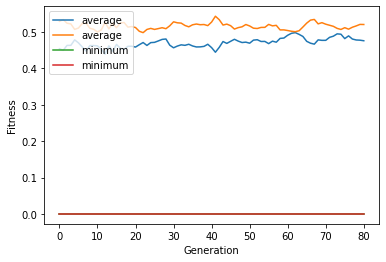

In [342]:
print("Best individual has fitness:", hof[0].fitness)
# generate tree.pdf with visualization of best individual
visualize2(hof[0])
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

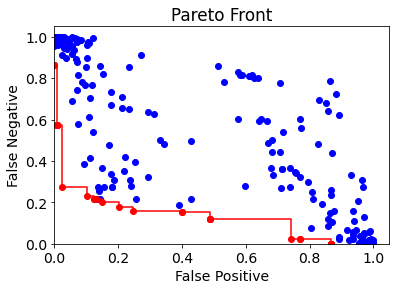

Area Under Curve: 0.1365428853105488


In [314]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in population]
pop_2 = [ind.fitness.values[1] for ind in population]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Positive")
plt.ylabel("False Negative")
plt.title("Pareto Front")
plt.ylim(bottom=0.0)
plt.xlim(left=0.0)
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

In [258]:
def evol_alt(ngen = 40, lambda_ = 100, var = True, sel = "NSGA2", cxpb = 0.5, mutpb = 0.2):
    pop = toolbox.population(lambda_)
    last_pop = []
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.value = fit
    for g in range(ngen):
        print("Generation:", g)
        offspring = toolbox.select(pop, lambda_)
        offspring = list(map(toolbox.clone, offspring))
        for parent1, parent2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.crossover(parent1, parent2)
                del(parent1.fitness.values)
                del(parent2.fitness.values)
        for l in range(lambda_):
            if random.random() < mutpb:
                toolbox.mutate(pop[1])
                del(pop[1].fitness.values)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = ind.fitness.values + fit
        pop[:] = offspring
    print("End of", g, "generations")
    return [list(toolbox.evaluate(indiv)) for indiv in pop], pop

In [259]:
def find_pareto(data):
    is_Pareto = np.ones(data.shape[0], dtype = bool)
    for i, c in enumerate(data):
        # Keep any point with a lower cost
        if is_Pareto[i]:
            # This is where you would change for miniminzation versus maximization 

            # Minimization
            is_Pareto[is_Pareto] = np.any(data[is_Pareto]<c, axis=1)  

            # Maximization
            #is_Pareto[is_Pareto] = np.any(data[is_Pareto]>c, axis=1)  

            # And keep self
            is_Pareto[i] = True  

    # Downsample from boolean array
    Pareto_data = data[is_Pareto, :]
    # Sort data
    Pareto_out =  Pareto_data[np.argsort(Pareto_data[:,0])]

    #return is_Pareto
    return Pareto_out, is_Pareto

Generation: 0
Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
End of 39 generations


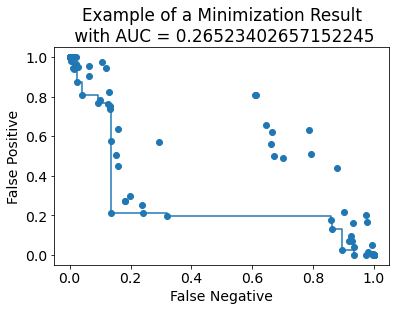

In [260]:
myData, pop = evol_alt(ngen = 40)
# Use above routine to find pareto points
myData = np.vstack(([[0,1],[1,0]], myData))
myPareto, is_Pareto = find_pareto(np.array(myData))

# Calculate the Area under the Curve as a Riemann sum
auc = np.sum(np.diff(myPareto[:,0])*myPareto[0:-1,1])

# Create figure
plt.figure()

# Make sure font sizes are large enough to read in the presentation
plt.rcParams.update({'font.size': 14})

# Plot all points
plt.scatter(myData[:,0],myData[:,1],)

# Plot Pareto steps. note 'post' for minimization 'pre' for maximization
plt.step(myPareto[:,0], myPareto[:,1], where='post')
#plt.step(myPareto[:,0], myPareto[:,1], where='pre')

# Make sure you include labels
# Minimization
plt.title('Example of a Minimization Result\n with AUC = ' + str(auc))
plt.xlabel('False Negative')
plt.ylabel('False Positive')

# Maximization
#plt.title('Example of a Maximization Result')
#plt.xlabel('True Negative')
#plt.ylabel('True Positive')

plt.show()

In [261]:
# cool examples in deap https://www.programcreek.com/python/example/104502/deap.base.Toolbox

import pickle
## fnction to pickle best individuals
def log_individuals(file):
    def decorator(func):
        def wrapper(*args, **kargs):
            individuals = func(*args, **kargs)
            for ind in individuals:
                pickle.dump(ind, file)
            return individuals
        return wrapper
    return decorator

# toolbox.register("generate")
# toolbox.decorate("generate", log_individuals(open("out.pkl", "w")))

In [262]:
predictions = [ind for ind in hof]    

In [263]:
test_df = pd.read_csv("processed_test.csv", index_col = "PassengerId")
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LastName,IsWomanOrBoy,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Single,SmallF,MedF,LargeF,Deck
PassengerId,,,,,,,,,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,1,10,401,0,3,3.0,1.0,0,1,0,0,0,7
893,3,0,47.0,1,0,7.0000,2,11,846,1,1,0.0,0.0,0,0,1,0,0,7
894,2,1,62.0,0,0,9.6875,1,10,552,0,0,0.0,0.0,1,1,0,0,0,7
895,3,1,27.0,0,0,8.6625,2,10,854,0,0,0.0,0.0,1,1,0,0,0,7
896,3,0,22.0,1,1,12.2875,2,11,342,1,2,1.0,0.5,0,0,0,1,0,7


In [264]:
def eval_test(points, pset):
    out = pd.DataFrame(index=test_df.index)
    index = 0
    for ind in predictions:
        func = gp.compile(expr=ind, pset=pset)
        results = [func(*points[x]) for x in range(len(points))]
        out[index] = results
        index += 1
    return out

In [265]:
out = eval_test(test_df.values, pset)
type(out)

pandas.core.frame.DataFrame

In [266]:
out.shape

(418, 30)

In [267]:
out.to_csv("titanic_deap.csv")